# Testing the optimization run for convergence:

In [3]:
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pymoo.indicators.hv import HV

In [4]:
import matplotlib
import matplotlib.font_manager as fm

# sns.set(font_scale=1.2)

fm.fontManager.addfont("Minion Pro Regular.ttf")
matplotlib.rc("font", family="Minion Pro")

from matplotlib import rcParams

rcParams["font.family"] = "Minion Pro"
rcParams["font.sans-serif"] = "Minion Pro"
rcParams["font.size"] = 12

## Epsilon progress:

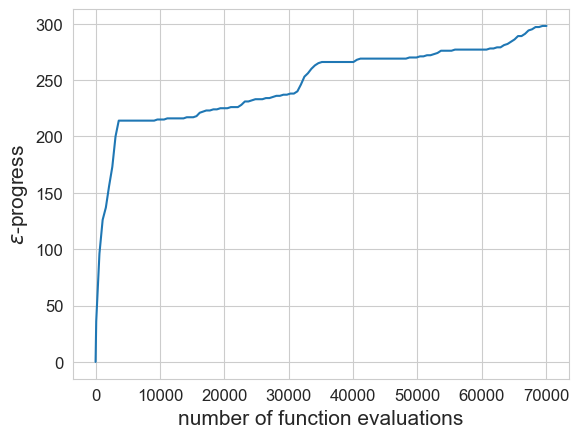

In [24]:
# Epsilon progress is already saved during the optimization

grouped = ["Baseline_grouped", "120Hurst_grouped"][1]
convergence = pd.read_csv(f"../outputs{grouped}/baseline_convergence.csv")
fig, ax = plt.subplots()
ax.set_xlabel("number of function evaluations", fontsize=15)
ax.set_ylabel("$\epsilon$-progress", fontsize=15)
ax.plot(convergence.nfe, convergence.epsilon_progress)
plt.show()

## Hypervolume:

Let's find the best and worst possible results for all objectives (to normalize them within 0-1 interval) except Sudan's 90th percentile worst month (as it is always 0). I will determine the best and worst possible values for each objective among all the archivelogged sets as well as the final pareto-front:

In [25]:
obj_indexes = [-6, -5, -4, -3, -2, -1]  # To get rid of Sudan objectives
directions = [
    "min",
    "min",
    "min",
    "min",
    "min",
    "max",
]  # Only GERD Hydropower is a maximization objective
best = [
    1e9,
    1e9,
    1e9,
    1e9,
    1e9,
    0,
]  # Initialize the set of best values with _ bad results (the aim is to reach the real best with the for loop)
worst = [0, 0, 0, 0, 0, 1e10]  # Same idea, initialize the worst as something very good

csvs_to_read = [f"../outputs{grouped}/archive_logs{grouped}/archive_{i}.csv" for i in range(2, 134)]
# csvs_to_read.append(
#     "../outputs/baseline_results.csv"
# )  # All archived solutions + final set

for file in csvs_to_read:
    current_df = pd.read_csv(file).iloc[:, obj_indexes]
    for i, col in enumerate(current_df.columns):
        # Updating the bests and worsts by looking at each solution:
        if directions[i] == "min":
            if current_df[col].max() > worst[i]:
                worst[i] = current_df[col].max()
            if current_df[col].min() < best[i]:
                best[i] = current_df[col].min()
        if directions[i] == "max":
            if current_df[col].max() > best[i]:
                best[i] = current_df[col].max()
            if current_df[col].min() < worst[i]:
                worst[i] = current_df[col].min()

In [26]:
print(best)
print(worst)

[0.0373456739096987, 0.0290542676668886, 0.0957208461215929, 0.0, 0.0, 16.926089397280343]
[0.9727469035396276, 0.9830796147864926, 15.443932743991406, 0.8416666666666667, 2.944795856137437, 8.594595228932006]


In [27]:
# Normalize objectives function makes the best outcome 1, worst 0 for each obj value
def normalize_objs(df, worst, best):
    for i, col in enumerate(df.columns):
        df[col] = (best[i] - df[col]) / (best[i] - worst[i])

    return np.array(df)

In [28]:
from tqdm import tqdm

# Let's calculate hypervolume per NFE to plot
hvs = np.empty(0)
nfes = np.empty(0)
hv = HV(ref_point=np.array([1.2, 1.2, 1.2, 1.2, 1.2, 1.2]))  # Reference set, works fine since everything is btwn 0-1

for i in tqdm(
    range(2, 134)
):  # We have that 82 archive logs, first doesn't have a solution
    if i <= 20:
        nfes = np.append(nfes, 500 * i)  # Convergence check frequency is 500 NFEs
    else:
        if i > 20 and i <= 25:
            nfes = np.append(nfes, 10000 + (i - 20) * (714.4))
        if i > 25:
            nfes = np.append(nfes, 13572 + (i - 25) * (752))

    # print(i, "I am here NFE")
    hvs = np.append(
        hvs,
        (
            hv.do(
                normalize_objs(  # Read and normalize data frames with 5 objectives
                    pd.read_csv(f"../outputs{grouped}/archive_logs{grouped}/archive_{i}.csv").iloc[
                        :, obj_indexes
                    ],
                    worst,
                    best,
                )
            )
        ),
    )
    
print(hvs[len(hvs) - 1])
    # print(i, "I am here HV")

100%|██████████| 132/132 [00:02<00:00, 46.19it/s]

2.4727613457895563


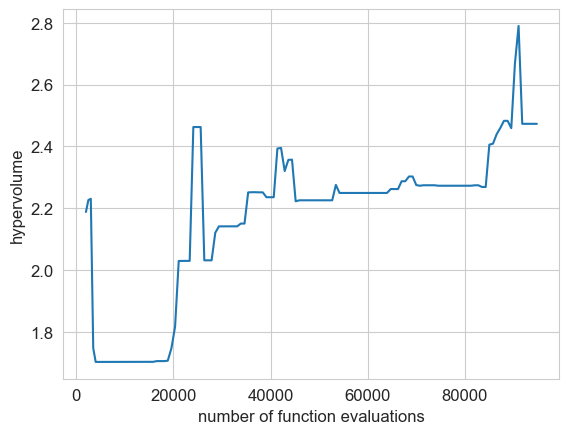

In [29]:
fig, ax = plt.subplots()
ax.set_xlabel("number of function evaluations")
ax.set_ylabel("hypervolume")
ax.plot(
    nfes[2:], hvs[2:]
)  # First 6 distorts the view, giving a wrong sense of convergence
plt.show()

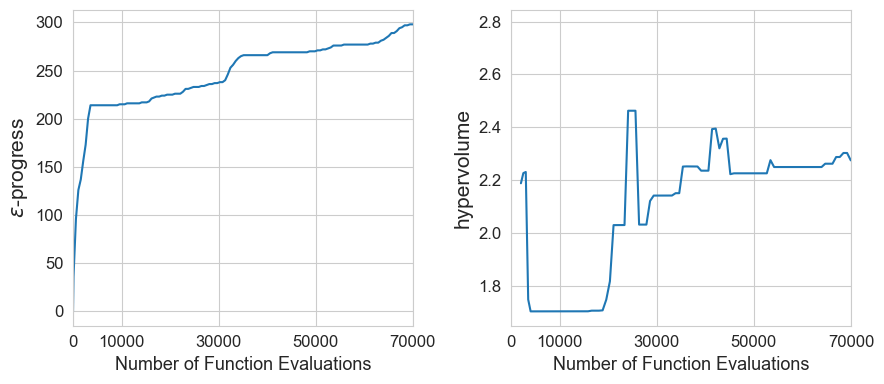

In [30]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(9, 4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel("$\epsilon$-progress", fontsize=15)
ax2.plot(nfes[2:], hvs[2:])
ax2.set_ylabel("hypervolume", fontsize=15)

ax1.set_xlabel("Number of Function Evaluations", fontsize=13)
ax1.set_xlim(0, 70000)
ax2.set_xlabel("Number of Function Evaluations", fontsize=13)
ax2.set_xlim(0, 70000)

ticks = (0, 10000, 30000, 50000, 70000)
ax1.set_xticks(ticks)
ax2.set_xticks(ticks)

fig.tight_layout()
# plt.grid(False)
plt.savefig("../plots/convergence.svg")
plt.show()

Interestingly epsilon progress suggests there is room for improvement however hypervolume hints at the opposite with **50,000** NFEs!